idefics2 generator experiments

In [1]:
import requests
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import Idefics2Processor, Idefics2Model, Idefics2ForConditionalGeneration
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import decord
import numpy as np

In [2]:
def get_video_frames(video_path: str, num_frames: int=32, start_frame: int=-1, end_frame: int=-1):
    # Load the video
    vr = decord.VideoReader(video_path)
    if start_frame == -1:
        start_frame = 0
    if end_frame == -1:
        end_frame = len(vr)
    segment_frame_count = end_frame - start_frame
    frame_delta = segment_frame_count // num_frames
    # get the first num_frames frame indices from the segment
    frame_idx = [start_frame+i*frame_delta for i in range(num_frames)]
    # if frame_idx has more elements than num_frames, remove the last element
    if len(frame_idx) > num_frames:
        frame_idx = frame_idx[:-1]       
    
    frames = torch.tensor(vr.get_batch(frame_idx).asnumpy(), dtype=torch.float32)
    return frames

In [3]:
model = Idefics2ForConditionalGeneration.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    torch_dtype=torch.bfloat16
).to("cuda")

processor = Idefics2Processor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


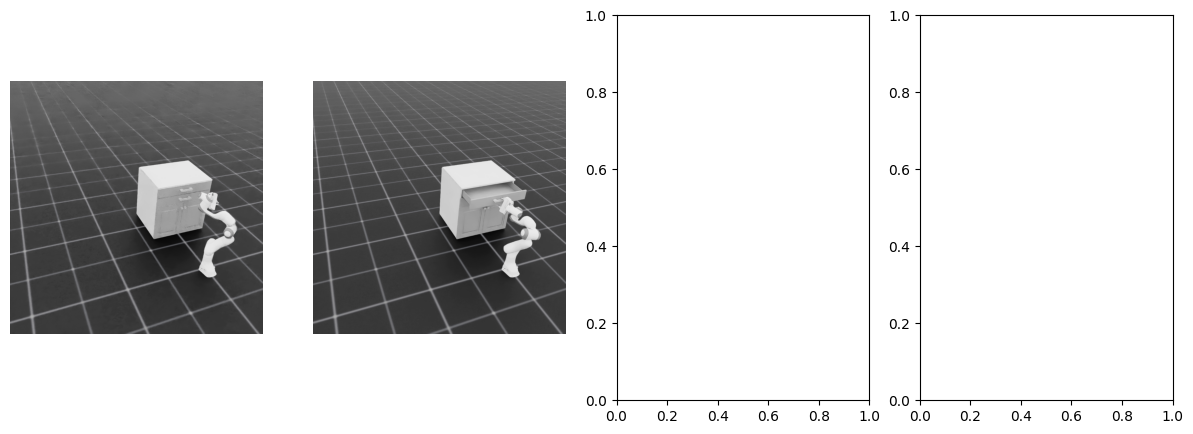

In [4]:
video_path = "/home/levi/data/dev_videos/franka_cabinet_896px_cam_high/franka_cabinet_video_chpnt_4375000_timesteps_1.mp4"
frames = get_video_frames(video_path, num_frames=2, start_frame=10, end_frame=150)
# Convert frames to PIL images
images1 = [Image.fromarray(frame.numpy().astype(np.uint8)) for frame in frames]

video_path = "/home/levi/data/dev_videos/franka_cabinet_896px_cam_high/franka_cabinet_video_chpnt_4375000_timesteps_1.mp4"
frames = get_video_frames(video_path, num_frames=4, start_frame=10, end_frame=150)
# Convert frames to PIL images
images2 = [Image.fromarray(frame.numpy().astype(np.uint8)) for frame in frames]

# print each of the frames side by side
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, image in enumerate(images1):
    axs[i].imshow(image)
    axs[i].axis("off")
plt.show()

In [8]:
messages = messages = [{
    "role": "user",
    "content": [
        {"type": "text", "text": 'What is the difference between these two images?'}
        ] +
        [
        {"type": "image"} for _ in range(len(images1))
        ] 
}]

In [22]:
print(messages)

[{'role': 'user', 'content': [{'type': 'text', 'text': 'Which of the two images best represents the task command: "Grab the cabinet top drawer handle and open the drawer"?'}, {'type': 'image'}, {'type': 'image'}]}]


In [9]:
images = images1

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(text=prompt, images=images , return_tensors="pt").to("cuda")


In [10]:
generated_text = model.generate(**inputs, max_new_tokens=500)
generated_text = processor.batch_decode(generated_text, skip_special_tokens=True)[0]
print("Generated text:", generated_text)

Generated text: User: What is the difference between these two images? 
Assistant: The robot is holding the drawer in the first image while it is not in the second image.
